## Setup

In [1]:
!pip install -qq seaborn

In [2]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from datasets import DatasetDict, VerificationMode, load_dataset
from tqdm.auto import tqdm

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Option #1: Load data from huggingface 

Run `huggingface-cli login` now.

In [5]:
datasets_variants = DatasetDict(
    {
        variant: load_dataset(
            "dasyd/time-qa",
            variant,
            data_dir=variant,
            data_files={split: f"{split}-*" for split in ["train", "val", "test"]},
            verification_mode=VerificationMode.NO_CHECKS,
        ).remove_columns("trajectory")
        for variant in ["binary", "multi", "open"]
    }
)
datasets_variants

Generating test split: 100%|██████████| 4539/4539 [00:01<00:00, 2588.03 examples/s]


DatasetDict({
    binary: DatasetDict({
        train: Dataset({
            features: ['sample_id', 'question_id', 'action_sequence', 'textual_description', 'question_type', 'question', 'answer_type', 'answer_text', 'answer'],
            num_rows: 49454
        })
        val: Dataset({
            features: ['sample_id', 'question_id', 'action_sequence', 'textual_description', 'question_type', 'question', 'answer_type', 'answer_text', 'answer'],
            num_rows: 6235
        })
        test: Dataset({
            features: ['sample_id', 'question_id', 'action_sequence', 'textual_description', 'question_type', 'question', 'answer_type', 'answer_text', 'answer'],
            num_rows: 6115
        })
    })
    multi: DatasetDict({
        train: Dataset({
            features: ['sample_id', 'question_id', 'action_sequence', 'textual_description', 'question_type', 'question', 'answer_type', 'answer_text', 'options', 'answer', 'options_sequence'],
            num_rows: 34927
     

In [7]:
data = pd.concat(
    [pd.DataFrame(split) for variant in datasets_variants.values() for split in variant.values()],
    ignore_index=True,
)
data.head()

,sample_id,question_id,action_sequence,textual_description,question_type,question,answer_type,answer_text,answer,options,options_sequence
0,0,3,"{'start': [0.0, 4.0, 8.0, 12.0], 'end': [4.0, ...",The person is starting the sequence with holdi...,comparison_timestamp_same_binary,Is the action at 8.174 the same as the action ...,binary,No,0.0,NaN,NaN
1,0,4,"{'start': [0.0, 4.0, 8.0, 12.0], 'end': [4.0, ...",The person is starting the sequence with holdi...,interval_part_sequence_binary,Did the person perform exactly 2 different act...,binary,False,0.0,NaN,NaN
2,1,1,"{'start': [0.0, 4.0, 8.0, 12.0], 'end': [4.0, ...","As the first action, the person is jumping onc...",comparison_first_last_different_binary,Can we say that the initial and final actions ...,binary,This is correct!,1.0,NaN,NaN
3,1,4,"{'start': [0.0, 4.0, 8.0, 12.0], 'end': [4.0, ...","As the first action, the person is jumping onc...",interval_part_sequence_binary,Is it true that the person is performing exact...,binary,This is not correct.,0.0,NaN,NaN
4,2,1,"{'start': [0.0, 4.0, 8.0, 12.0], 'end': [4.0, ...",The person is starting the sequence with jumpi...,after_binary,Did the person transition to running at a late...,binary,Yes,1.0,NaN,NaN


## Option #2: Load local data

In [8]:
# base_path = Path(".").absolute().parents[1] / "generated-dataset-30_000" / "data"

# assert base_path.exists()

In [9]:
# def get_instances():
#     for file in base_path.glob("*/data.json"):
#         with open(file) as f:
#             as_json = json.load(f)

#         def answer_mapping(answer_type, answer, options, correct_option):
#             match answer_type:
#                 case "binary":
#                     correct = str(options[correct_option])
#                     return {"True": "A", "False": "B"}[correct]
#                 case "multi":
#                     return correct_option
#                 case _:
#                     return answer

#         action_sequence = [entry["action"] for entry in as_json["prompt_sequence"]]

#         yield from (
#             {
#                 "sample_id": str(file.parts[-2]),
#                 "question_id": question_id,
#                 "textual_description": as_json["textual_description"],
#                 "question_type": qa_pair["question_type"],
#                 "question": qa_pair["question"],
#                 "answer_type": qa_pair["answer_type"],
#                 "answer": answer_mapping(
#                     qa_pair["answer_type"], qa_pair["answer"], qa_pair["options"], qa_pair["correct_option"]
#                 ),
#                 "action_sequence": action_sequence,
#             }
#             for question_id, qa_pair in enumerate(as_json["qa_pairs"])
#         )


# data = pd.DataFrame.from_records(list(tqdm(get_instances())))

## Handling

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   sample_id            150000 non-null  int64  
 1   question_id          150000 non-null  int64  
 2   action_sequence      150000 non-null  object 
 3   textual_description  150000 non-null  object 
 4   question_type        150000 non-null  object 
 5   question             150000 non-null  object 
 6   answer_type          150000 non-null  object 
 7   answer_text          150000 non-null  object 
 8   answer               105403 non-null  float64
 9   options              43599 non-null   object 
 10  options_sequence     43599 non-null   object 
dtypes: float64(1), int64(2), object(8)
memory usage: 12.6+ MB


In [11]:
data.rename(
    columns={
        "textual_description": "Description",
        "question_type": "Question Type",
        "question": "Question",
        "answer_type": "Answer Type",
        "answer": "Answer",
        "action_sequence": "Action Sequence",
    },
    inplace=True,
)

In [12]:
data = data.sort_values(by=["Answer Type"])

In [13]:
data["unique_id"] = data["sample_id"].astype(str) + "_" + data["question_id"].astype(str)
data["Action Sequence"] = data["Action Sequence"].apply(lambda x: " - ".join(x))
data

,sample_id,question_id,Action Sequence,Description,Question Type,Question,Answer Type,answer_text,Answer,options,options_sequence,unique_id
0,0,3,start - end - action - action_sentence,The person is starting the sequence with holdi...,comparison_timestamp_same_binary,Is the action at 8.174 the same as the action ...,binary,No,0.0,NaN,NaN,0_3
41195,20018,2,start - end - action - action_sentence,The activity golfing (swinging a club) is the ...,interval_part_sequence_binary,Is the statement accurate that the individual ...,binary,True,1.0,NaN,NaN,20018_2
41196,20018,3,start - end - action - action_sentence,The activity golfing (swinging a club) is the ...,comparison_timestamp_different_binary,Do the actions at 14.052 and 12.567 vary?,binary,This is not true.,0.0,NaN,NaN,20018_3
41197,20018,4,start - end - action - action_sentence,The activity golfing (swinging a club) is the ...,comparison_first_last_same_binary,Is the first action identical to the last action?,binary,No,0.0,NaN,NaN,20018_4
41198,20019,0,start - end - action - action_sentence,The sequence starts with kicking a ball. It is...,before_binary,Did running come some time before catching a b...,binary,False,0.0,NaN,NaN,20019_0
...,...,...,...,...,...,...,...,...,...,...,...,...
120270,9986,2,start - end - action - action_sentence,The first activity the person is doing is punc...,extremum_most_open,Which activity had the highest repetition occu...,open,punching,NaN,NaN,NaN,9986_2
120271,9986,4,start - end - action - action_sentence,The first activity the person is doing is punc...,count_open,How often does the person carry out punching?,open,2,NaN,NaN,NaN,9986_4
120272,9987,0,start - end - action - action_sentence,"As the first action, the person is sitting dow...",extremum_least_open,"Given the sequence, which activity had the lea...",open,"sitting down, catching a ball, and picking som...",NaN,NaN,NaN,9987_0
120264,9979,4,start - end - action - action_sentence,"First, the person is kicking a ball. This acti...",right_before_open,What happened immediately before a person was ...,open,The subject is sitting down.,NaN,NaN,NaN,9979_4


In [14]:
binary = data[data["Answer Type"] == "binary"]
multi = data[data["Answer Type"] == "multi"]
binary_multi = pd.concat([binary, multi])
open_ = data[data["Answer Type"] == "open"]

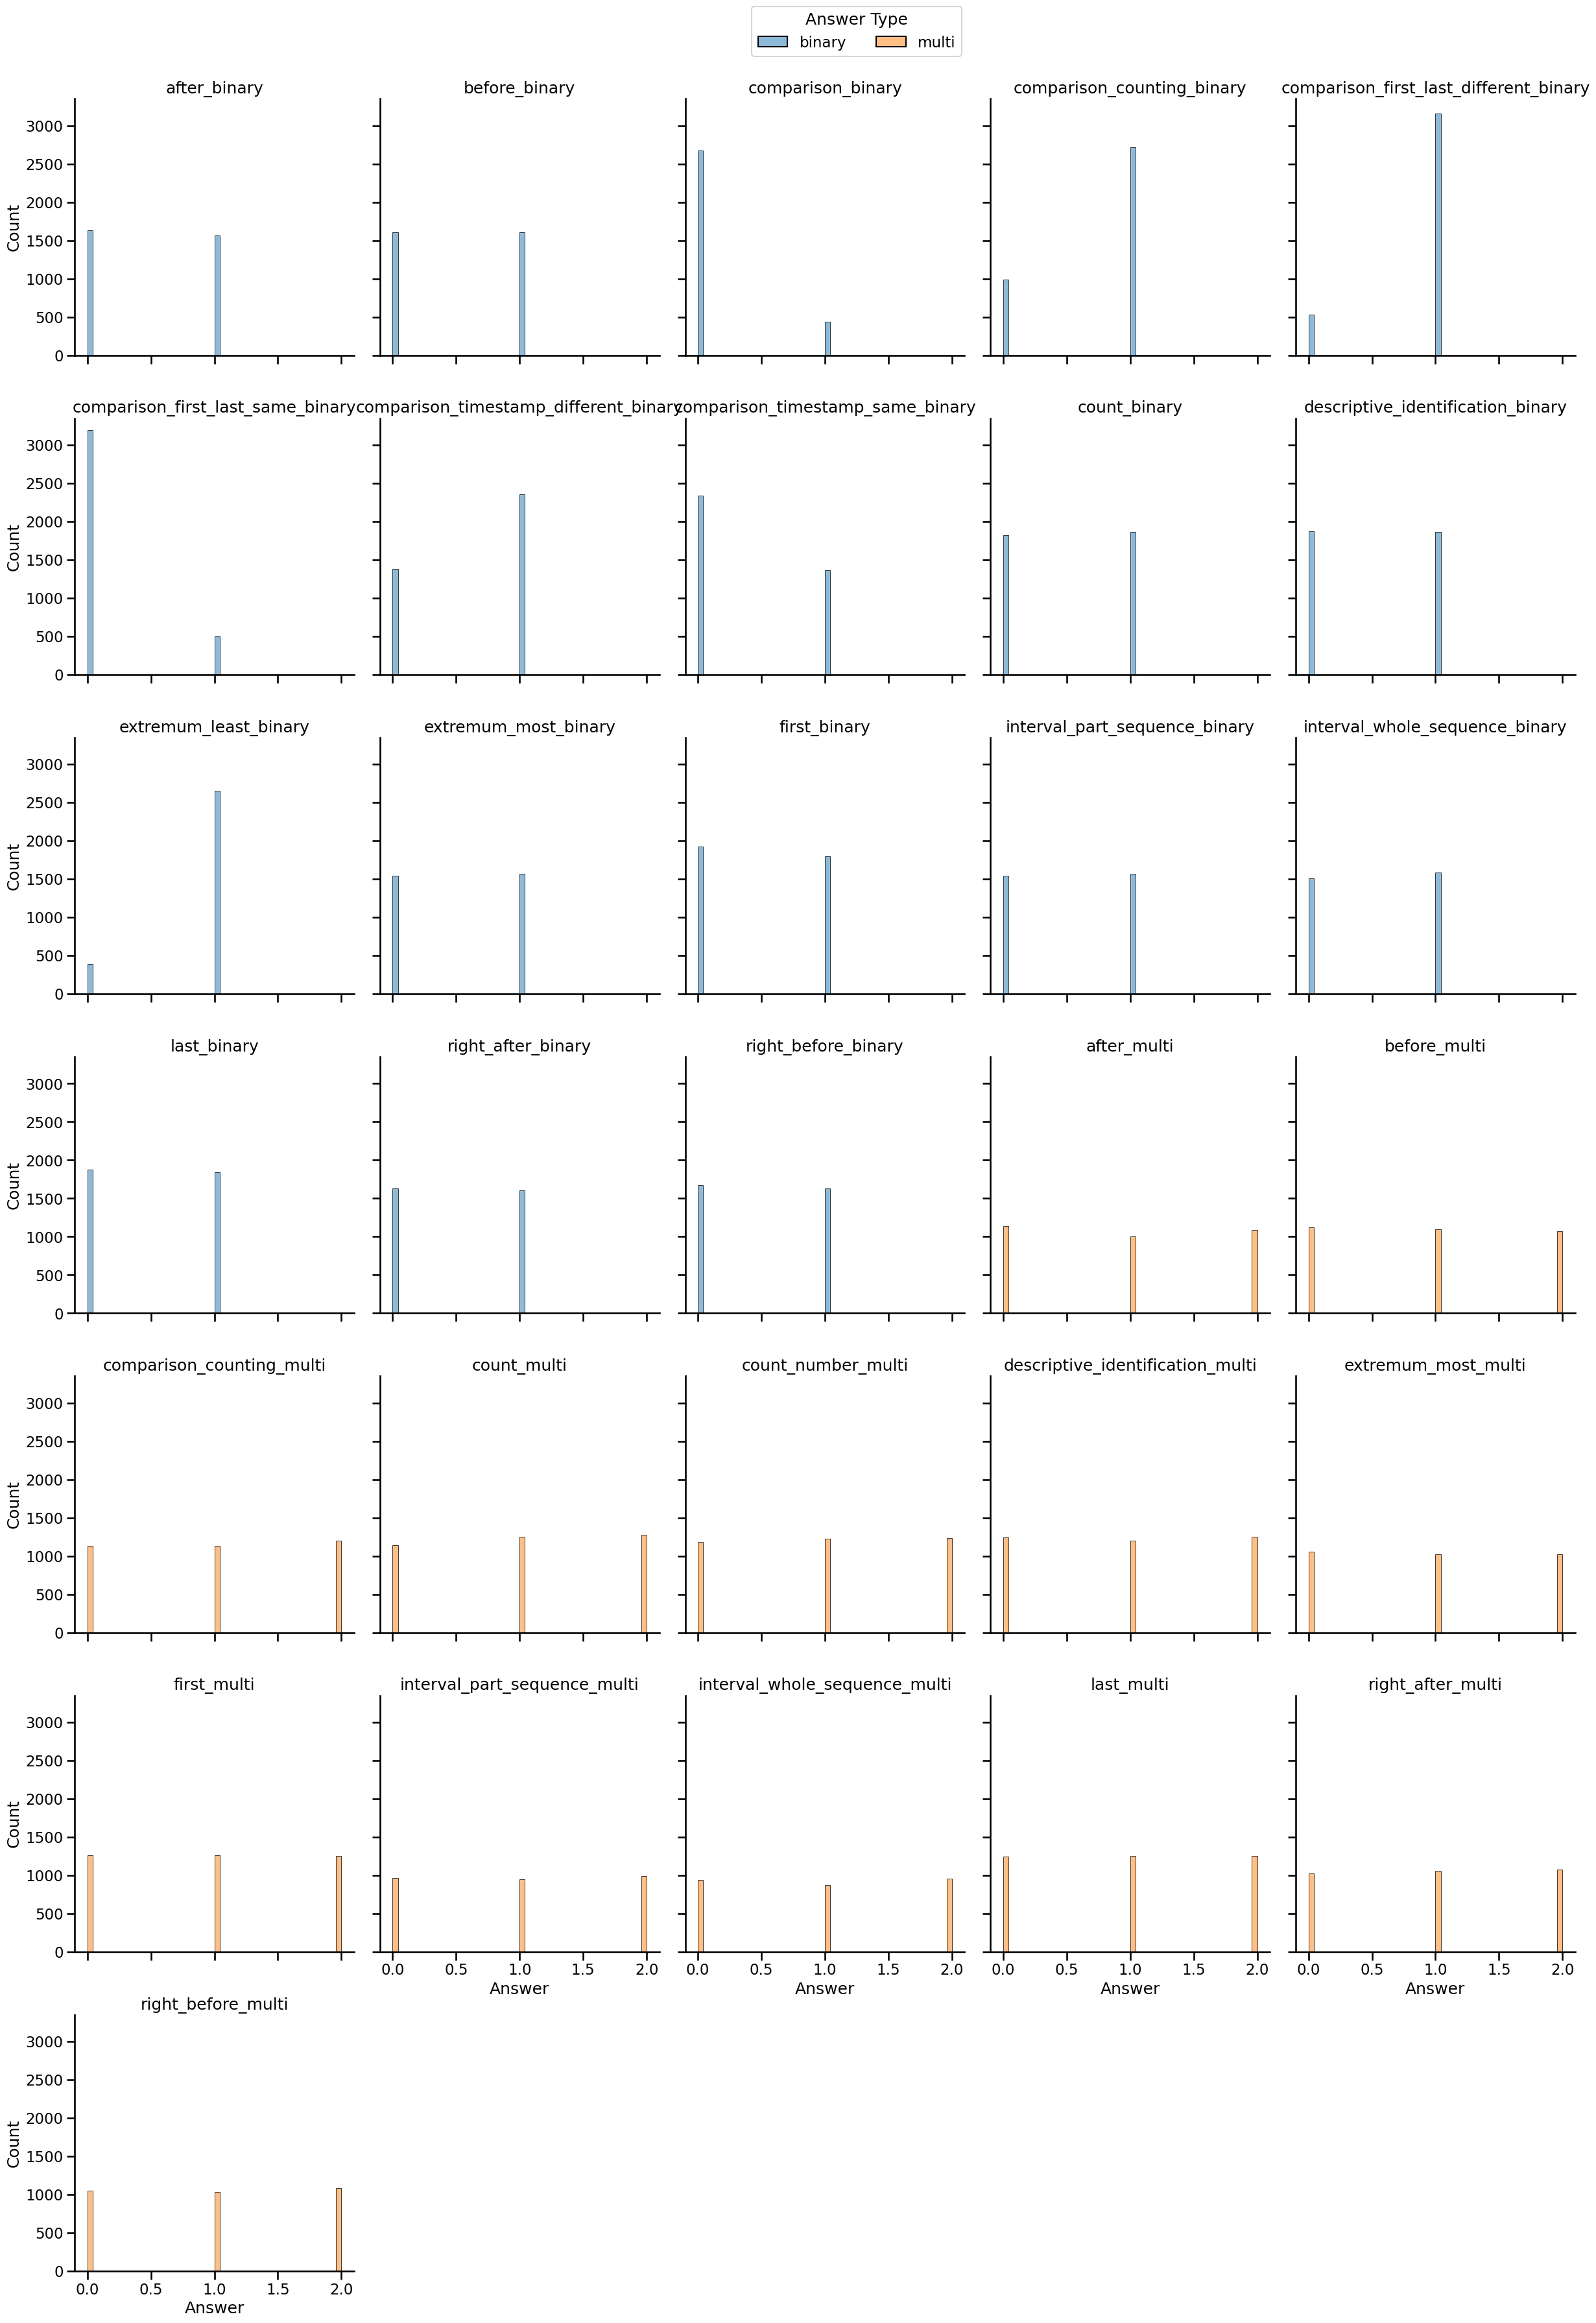

In [15]:
sns.set_context("talk")
g = sns.displot(
    data=binary_multi.sort_values(by=["Answer Type", "Question Type", "Answer"]),
    x="Answer",
    hue="Answer Type",
    col="Question Type",
    col_wrap=5,
)
g.set_titles("{col_name}")
sns.move_legend(g, "lower center", bbox_to_anchor=(0.5, 1), ncol=3, frameon=True)
plt.savefig("answer_distribution.pdf", bbox_inches="tight")
pass

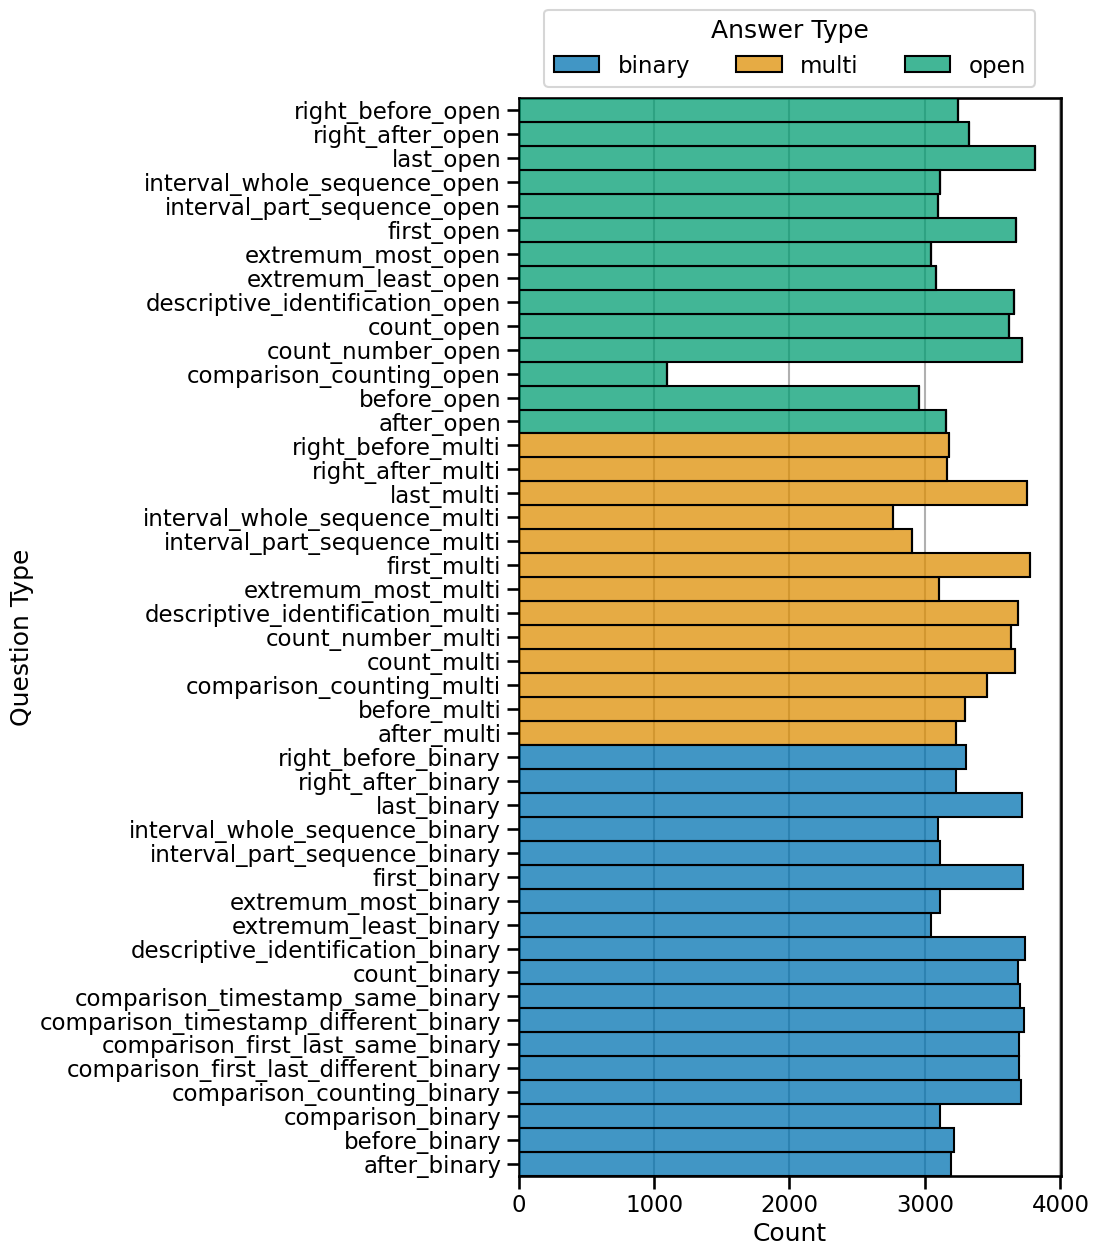

In [ ]:
plt.figure(figsize=(7, 14))
ax = sns.histplot(
    data=data.sort_values(by=["Answer Type", "Question Type"]),
    y="Question Type",
    hue="Answer Type",
    # shrink=0.75,
    multiple="stack",
    palette="colorblind",
    alpha=0.75,
    zorder=10,
)
ax.xaxis.grid(True, zorder=5)
ax.set_ylim(-0.5, len(data["Question Type"].unique()) - 0.5)
sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, 1), ncol=3, frameon=True)

plt.savefig("question_distribution.pdf", bbox_inches="tight", pad_inches=0)
pass

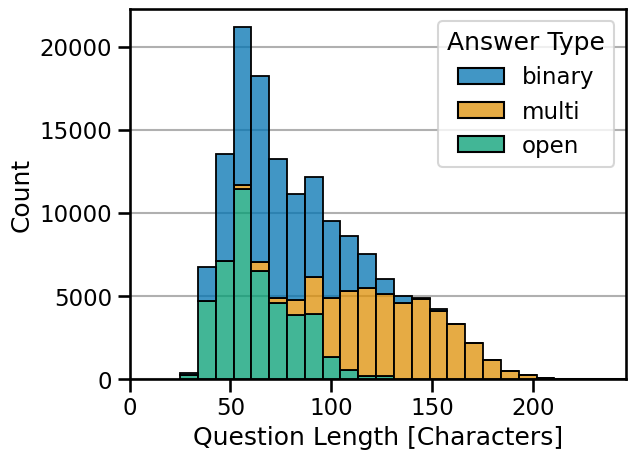

In [43]:
df = data.copy()
df["Question Length [Characters]"] = df["Question"].str.len()
ax = sns.histplot(
    data=df,
    x="Question Length [Characters]",
    hue="Answer Type",
    bins=25,
    multiple="stack",
    palette="colorblind",
    alpha=0.75,
    zorder=10,
)
ax.yaxis.grid(True, zorder=5)
ax.set_xlim(0, df["Question Length [Characters]"].max())

plt.savefig("question_length_histogram.pdf", bbox_inches="tight", pad_inches=0)
pass

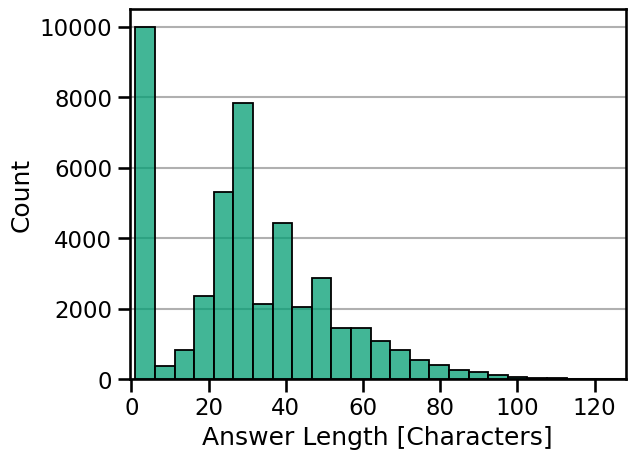

In [52]:
df = open_.copy()
df["Answer Length [Characters]"] = df["answer_text"].str.len()
ax = sns.histplot(
    data=df,
    x="Answer Length [Characters]",
    bins=25,
    multiple="stack",
    color=sns.palettes.color_palette("colorblind")[2],
    alpha=0.75,
    zorder=10,
)
ax.yaxis.grid(True, zorder=5)
ax.set_xlim(-0.5, df["Answer Length [Characters]"].max())

plt.savefig("open_answer_length_histogram.pdf", bbox_inches="tight", pad_inches=0)
pass